Here we will model the simple network that contains two microorganims engaging in cross feeding from [Khandelwal et el 2013](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0064567)

![image.png](./images/synthetic_2_bact.png)

Getting Bacteria i to produce succinate is key to keeping both alive. The way to do this include randomly varying the objective funciton, messing with the ratios in the stoiciometric matrix. Key is to find the bifurcation points!! Look into the stoichiometric matrices to understand this... there is something special happening here ?!?!?!

In [4]:
import cobra
from cobra import Model, Metabolite, Reaction
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from cobra.io import read_sbml_model, write_sbml_model
import os

In [2]:
cobra_config = cobra.Configuration()
cobra_config.lower_bound = 0

## Bateria Models

In [3]:
def gen_bact_i_model():
    # microbe i
    bact_i_model = Model("Bact i")

    # metabolites
    glu_i = Metabolite("glu_i", compartment="c_i")
    nh3_i = Metabolite("nh3_i", compartment="c_i")
    succ_i = Metabolite("succ_i", compartment="c_i")
    atp_i = Metabolite("atp_i", compartment="c_i")
    nadh_i = Metabolite("nadh_i", compartment="c_i")
    
    biomass_i = Metabolite("Biomass_i", compartment="c_i")
    

    # reactions
    q_pro_i = Reaction("q_pro_i", lower_bound=None)
    q_pro_i.add_metabolites({glu_i:-1, nadh_i:1, atp_i:1, succ_i:1})

    q_cat_i = Reaction("q_cat_i", lower_bound=None)
    q_cat_i.add_metabolites({glu_i:-1, nadh_i:1, atp_i:1})

    q_resp_i = Reaction("q_resp_i", lower_bound=None)
    q_resp_i.add_metabolites({nadh_i:-1, atp_i:1})

    q_ana_i = Reaction("q_ana_i", lower_bound=None)
    q_ana_i.add_metabolites({ nh3_i:-1, atp_i:-1, biomass_i:1, nadh_i:1})

    bact_i_model.add_reactions([q_pro_i, q_cat_i, q_resp_i, q_ana_i])
    # bact_i_model.add_reactions([q_pro_i, q_resp_i, q_ana_i])


    # ingestions and excretions
    q_glu_i = Reaction("q_glu_i", lower_bound=None)
    q_glu_i.add_metabolites({glu_i:1})

    q_nh3_i = Reaction("q_nh3_i", lower_bound=None)
    q_nh3_i.add_metabolites({nh3_i:1})

    q_succ_i = Reaction("q_succ_i", lower_bound=None)
    q_succ_i.add_metabolites({succ_i:-1})

    bact_i_model.add_reactions([q_glu_i, q_nh3_i, q_succ_i])


    # biomass reaction
    biomass_i_rxn = Reaction("Biomass_i_rxn", lower_bound=None)
    biomass_i_rxn.add_metabolites({biomass_i:-1})
    bact_i_model.add_reactions([biomass_i_rxn])

    # set objective
    bact_i_model.objective = {biomass_i_rxn:1}

    return bact_i_model

def gen_bact_j_model():
  bact_j_model = Model("Bact j")

  # metabolites
  succ_j = Metabolite("succ_j", compartment="c_j")
  nh3_j = Metabolite("nh3_j", compartment="c_j")
  n2_j = Metabolite("n2_j", compartment="c_j")
  atp_j = Metabolite("atp_j", compartment="c_j")
  nadh_j = Metabolite("nadh_j", compartment="c_j")
  biomass_j = Metabolite("biomass_j", compartment="c_j")


  # reactions
  q_cat_j = Reaction("q_cat_j", lower_bound=None)
  q_cat_j.add_metabolites({succ_j:-1, atp_j:1, nadh_j:1})

  q_resp_j = Reaction("q_res_j", lower_bound=None)
  q_resp_j.add_metabolites({nadh_j:-1, atp_j:1})

  q_pro_j = Reaction("q_pro_j", lower_bound=None)
  q_pro_j.add_metabolites({n2_j:-1, atp_j:-1, nh3_j:1})

  q_ana_j = Reaction("q_ana_j", lower_bound=None)
  q_ana_j.add_metabolites({nh3_j:-1, atp_j:-1, nadh_j:1, biomass_j:1})

  bact_j_model.add_reactions({q_cat_j, q_resp_j, q_pro_j, q_ana_j})

  # ingestions and excretions
  q_succ_j = Reaction("q_succ_j", lower_bound=None)
  q_succ_j.add_metabolites({succ_j:1})

  q_nh3_j = Reaction("q_nh3_j", lower_bound=None)
  q_nh3_j.add_metabolites({nh3_j:-1})

  q_n2_j = Reaction("q_n2_j", lower_bound=None)
  q_n2_j.add_metabolites({n2_j:1})

  bact_j_model.add_reactions([q_succ_j, q_nh3_j, q_n2_j])


  # biomass
  biomass_j_rxn = Reaction("Biomass_j_rxn", lower_bound=None, upper_bound=1)
  biomass_j_rxn.add_metabolites({biomass_j:-1})
  bact_j_model.add_reactions([biomass_j_rxn])

  bact_j_model.objective = {biomass_j_rxn:1, q_nh3_j:0.5}

  return bact_j_model

In [5]:
save_dir = "./models/test/"

bact_i_model = gen_bact_i_model()
write_sbml_model(bact_i_model, os.path.join(save_dir, "bact_i.xml"))

bact_j_model = gen_bact_j_model()
write_sbml_model(bact_j_model, os.path.join(save_dir, "bact_j.xml"))

In [13]:
bact_i_model = gen_bact_i_model()
for reaction in bact_i_model.reactions:
    print(f"{reaction.id}:\t{reaction.build_reaction_string()}")
    # print(f"\t\tlb:{reaction.lower_bound}, ub:{reaction.upper_bound}")
    # print('-'*100)
bact_i_model.optimize()

q_pro_i:	glu_i --> atp_i + nadh_i + succ_i
q_cat_i:	glu_i --> atp_i + nadh_i
q_resp_i:	nadh_i --> atp_i
q_ana_i:	atp_i + nh3_i --> Biomass_i + nadh_i
q_glu_i:	 --> glu_i
q_nh3_i:	 --> nh3_i
q_succ_i:	succ_i --> 
Biomass_i_rxn:	Biomass_i --> 


,fluxes,reduced_costs
q_pro_i,0.0,0.0
q_cat_i,0.0,0.0
q_resp_i,1000.0,0.0
q_ana_i,1000.0,0.0
q_glu_i,0.0,-0.0
q_nh3_i,1000.0,2.0
q_succ_i,0.0,0.0
Biomass_i_rxn,1000.0,0.0


In [14]:
bact_j_model = gen_bact_j_model()
for reaction in bact_j_model.reactions:
    print(f"{reaction.id}:\t{reaction.build_reaction_string()}")
    # print(f"\t\tlb:{reaction.lower_bound}, ub:{reaction.upper_bound}")
    # print('-'*100)
bact_j_model.optimize()

q_cat_j:	succ_j --> atp_j + nadh_j
q_res_j:	nadh_j --> atp_j
q_ana_j:	atp_j + nh3_j --> biomass_j + nadh_j
q_pro_j:	atp_j + n2_j --> nh3_j
q_succ_j:	 --> succ_j
q_nh3_j:	nh3_j --> 
q_n2_j:	 --> n2_j
Biomass_j_rxn:	biomass_j --> 


,fluxes,reduced_costs
q_cat_j,500.0,0.0
q_res_j,501.0,0.0
q_ana_j,1.0,0.0
q_pro_j,1000.0,0.0
q_succ_j,500.0,0.0
q_nh3_j,999.0,0.0
q_n2_j,1000.0,1.0
Biomass_j_rxn,1.0,1.0


## Dynamical System Setup

In [175]:
import random

In [191]:
bact_i_model = gen_bact_i_model()
bact_j_model = gen_bact_j_model()

q_glu_i_srs = []
q_nh3_i_srs = []
q_succ_i_srs = []

q_nh3_j_srs = []
q_n2_j_srs = []
q_succ_j_srs = []


def ODE_community(t, y):
  # parse the concentrations
  glu_conc, nh3_conc, n2_conc, succ_conc, biomass_i_conc, biomass_j_conc = y

  # update lower bound 
  bact_i_model.reactions.q_glu_i.uppr_bound = max(glu_conc,0)
  bact_i_model.reactions.q_nh3_i.upper_bound = max(nh3_conc,0)

  bact_j_model.reactions.q_n2_j.upper_bound = max(n2_conc,0)
  bact_j_model.reactions.q_succ_j.upper_bound = max(succ_conc,0)

  # randomly change objective
  # bact_i_model.objective = {bact_i_model.reactions.Biomass_i_rxn:0.7,
  #                            bact_i_model.reactions.q_succ_i:random.random()}
  # bact_j_model.objective = {bact_j_model.reactions.Biomass_j_rxn: 1,
  #                            bact_j_model.reactions.q_nh3_j: random.random()}


  sol_i = bact_i_model.optimize()
  sol_j = bact_j_model.optimize()

  # parse the fluxes
  q_glu_i = sol_i.fluxes.q_glu_i
  q_nh3_i = sol_i.fluxes.q_nh3_i
  q_succ_i = sol_i.fluxes.q_succ_i
  mu_i = sol_i.fluxes.Biomass_i_rxn

  q_nh3_j = sol_j.fluxes.q_nh3_j
  q_n2_j = sol_j.fluxes.q_n2_j
  q_succ_j = sol_j.fluxes.q_succ_j
  mu_j = sol_j.fluxes.Biomass_j_rxn

  q_succ_i_srs.append(q_succ_i)
  q_nh3_i_srs.append(q_nh3_i)
  q_glu_i_srs.append(q_glu_i)
  
  q_succ_j_srs.append(q_succ_j)
  q_nh3_j_srs.append(q_nh3_j)
  q_n2_j_srs.append(q_n2_j)
  

  # compute the change
  # d_glu = - q_glu_i * biomass_i_conc if glu_conc > 0 else 0

  d_glu = 0

  if nh3_conc > 0:
    d_nh3 = - q_nh3_i * biomass_i_conc + q_nh3_j * biomass_j_conc
  else:
    d_nh3 = q_nh3_j * biomass_j_conc

  # d_n2 = - q_n2_j * biomass_j_conc
  d_n2 = 0
  
  if succ_conc > 0:
    d_succ = 2 * q_succ_i * biomass_i_conc - q_succ_j * biomass_j_conc
  else:
    d_succ = 2 * q_succ_i * biomass_i_conc
  # d_succ = 0.1
  
  d_biomass_i = mu_i - 0.2 * biomass_i_conc if biomass_i_conc > 0 else mu_i
  d_biomass_j = mu_j - 0.2 * biomass_j_conc if biomass_j_conc > 0 else mu_j


  return [d_glu, d_nh3, d_n2, d_succ, d_biomass_i, d_biomass_j]

# infeasible events 
neg_glu_event = lambda t,y: y[0]
neg_n2_event = lambda t,y: y[1] 
neg_nh3_event = lambda t,y: y[2] 
neg_succ_event = lambda t,y: y[3] 
neg_biomass_i_event = lambda t,y: y[4] 
neg_biomass_j_event = lambda t,y: y[5] 


neg_glu_event.terminal = False
neg_n2_event.terminal = False
neg_nh3_event.terminal = False
neg_succ_event.terminal = False
neg_biomass_i_event.terminal = False
neg_biomass_j_event.terminal = False

## Simulation

In [192]:
# "glucose", "nh3", "n2", "succ", "biomass_i", "biomass_j"
y0 = [10, 10, 5, 0, 1, 1]
solution = solve_ivp(ODE_community, t_span=(0,100), y0=y0,
                method="BDF", events=[neg_glu_event, neg_n2_event, neg_nh3_event,
                             neg_succ_event, neg_biomass_i_event, neg_biomass_j_event])

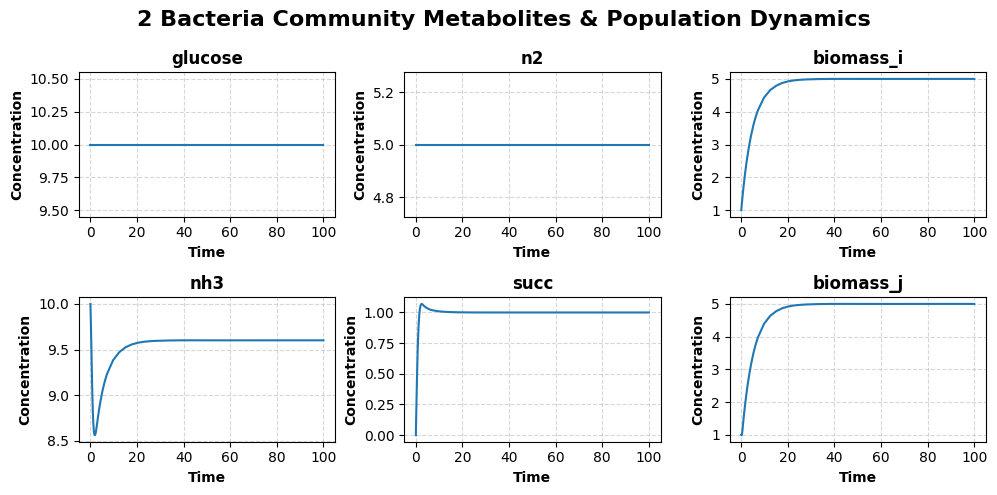

In [193]:
time = solution.t
glu_e_conc = solution.y[0]
nh3_e_conc = solution.y[1]
n2_e_conc = solution.y[2]
succ_e_conc = solution.y[3]
biomass_i_conc = solution.y[4]
biomass_j_conc = solution.y[5]

# for each time series, make a subplot
fig, ax = plt.subplots(2,3, figsize=(10,5))
time_srs_names = ["glucose","nh3", "n2", "succ", "biomass_i", "biomass_j"]

for i,name in enumerate(time_srs_names):
  r,c = i%2, i//2
  ax[r,c].plot(time, solution.y[i])
  ax[r,c].set_title(name, fontweight="bold")
  ax[r,c].set_xlabel("Time", fontweight="bold")
  ax[r,c].set_ylabel("Concentration", fontweight="bold")
  ax[r,c].grid(linestyle="--",alpha=0.5)

fig.suptitle("2 Bacteria Community Metabolites & Population Dynamics",
             fontsize=16, fontweight="bold")
plt.tight_layout()

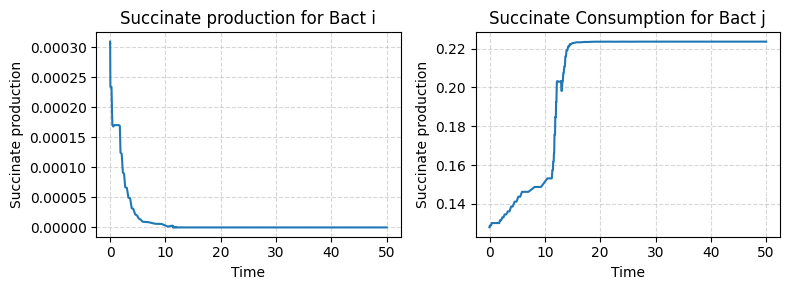

In [148]:
# plot the NH3 production for bact i and j in different subplots
fig, ax = plt.subplots(1,2, figsize=(8,3))
ax[0].plot(solution.t, q_succ_i_srs[-len(solution.t):])
ax[0].set_title("Succinate production for Bact i")
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Succinate production")
ax[0].grid(linestyle="--",alpha=0.5)

ax[1].plot(solution.t, q_succ_j_srs[-len(solution.t):])
ax[1].set_title("Succinate Consumption for Bact j")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Succinate production")
ax[1].grid(linestyle="--",alpha=0.5)

fig.tight_layout()

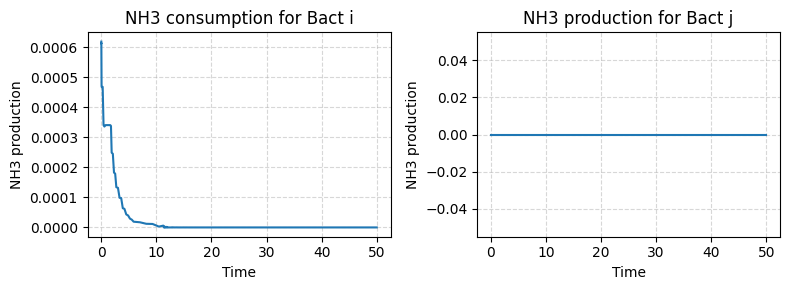

In [149]:
# plot the NH3 production for bact i and j in different subplots
fig, ax = plt.subplots(1,2, figsize=(8,3))
ax[0].plot(solution.t, q_nh3_i_srs[-len(solution.t):])
ax[0].set_title("NH3 consumption for Bact i")
ax[0].set_xlabel("Time")
ax[0].set_ylabel("NH3 production")
ax[0].grid(linestyle="--",alpha=0.5)

ax[1].plot(solution.t, q_nh3_j_srs[-len(solution.t):])
ax[1].set_title("NH3 production for Bact j")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("NH3 production")
ax[1].grid(linestyle="--",alpha=0.5)

fig.tight_layout()

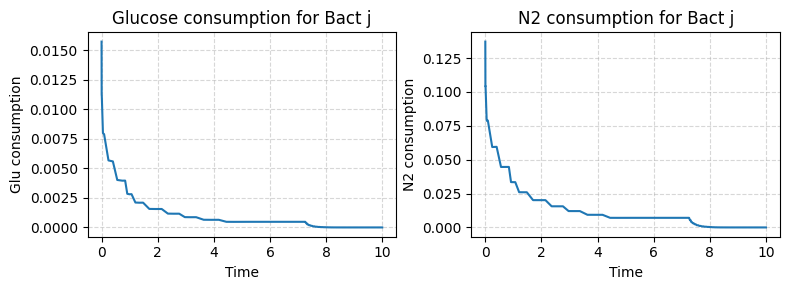

In [95]:
# plot the NH3 production for bact i and j in different subplots
fig, ax = plt.subplots(1,2, figsize=(8,3))
ax[0].plot(solution.t, q_glu_i_srs[-len(solution.t):])
ax[0].set_title("Glucose consumption for Bact j")
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Glu consumption")
ax[0].grid(linestyle="--",alpha=0.5)

ax[1].plot(solution.t, q_n2_j_srs[-len(solution.t):])
ax[1].set_title("N2 consumption for Bact j")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("N2 consumption")
ax[1].grid(linestyle="--",alpha=0.5)

fig.tight_layout()